<a href="https://colab.research.google.com/github/a-donat/Data-Science-Portfolio/blob/master/Kidney_CT_Scans_Multiclass_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diagnosis of Kidney CT Scans as Either Normal, Tumor, Cyst or Stone with a Convolutional Neural Network.**<br>
by Annalisa Donat

Overview: This analysis will train a Convolutional Neural Network to diagnose Kidney Scans as either Normal, Tumor, Cyst or Stone with an accuracy of over 99.7% on unseen data.

# I. Set Up

## I.A. Import Libraries

In [21]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import splitfolders
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## I.B. Download Data from Kaggle

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install kaggle


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d anima890/kidney-ct-scan
!unzip '/content/kidney-ct-scan.zip' -d '/content/kidney_ct_scan'

## I.C. Separate Data into Training, Validation, and Test Sets

In [26]:
unsorted_dir = "/content/kidney_ct_scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/\
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/"

sorted_dir = "sorted_kidney_ct_scans"


In [27]:
categories = ["Normal", "Cyst", "Tumor", "Stone"]

In [28]:
for c in categories:
  for fn in os.listdir(unsorted_dir + c):
    if Image.open(unsorted_dir + c + "/" + fn).width > 512:
      os.remove(unsorted_dir + c + "/" + fn)

In [29]:
for c in categories:
  print(c, len([x for x in os.listdir(unsorted_dir + c)]), "samples")

Normal 3274 samples
Cyst 2247 samples
Tumor 1340 samples
Stone 848 samples


In [30]:
splitfolders.ratio(unsorted_dir, output=sorted_dir, seed=0, ratio=(.7, 0.2,0.1)) 


Copying files: 7709 files [00:03, 2443.53 files/s]


In [31]:
for c in categories:
  print(c, len([x for x in os.listdir(
      "/content/sorted_kidney_ct_scans/train/" + c)]))

Normal 2291
Cyst 1572
Tumor 937
Stone 593


# II. Data Exploration and Visualization

In [32]:
train_folder = "/content/sorted_kidney_ct_scans/train/"

def get_info(cat_name, file_path):
  img = Image.open(file_path)
  return [file_path, cat_name, img.width, img.height, img.size]

sizes = [
    get_info(c, train_folder + c + "/" + fn) 
    for c in categories
    for fn in os.listdir(train_folder + c) ]

sizes_df = pd.DataFrame(
    sizes, columns=["filepath", "category", "width", "height", "size"])

In [33]:
sizes_df.head()

,filepath,category,width,height,size
0,/content/sorted_kidney_ct_scans/train/Normal/N...,Normal,512,512,"(512, 512)"
1,/content/sorted_kidney_ct_scans/train/Normal/N...,Normal,512,512,"(512, 512)"
2,/content/sorted_kidney_ct_scans/train/Normal/N...,Normal,512,512,"(512, 512)"
3,/content/sorted_kidney_ct_scans/train/Normal/N...,Normal,512,512,"(512, 512)"
4,/content/sorted_kidney_ct_scans/train/Normal/N...,Normal,512,512,"(512, 512)"


In [34]:
sizes_df.nunique()

filepath    5393
category       4
width          1
height         1
size           1
dtype: int64

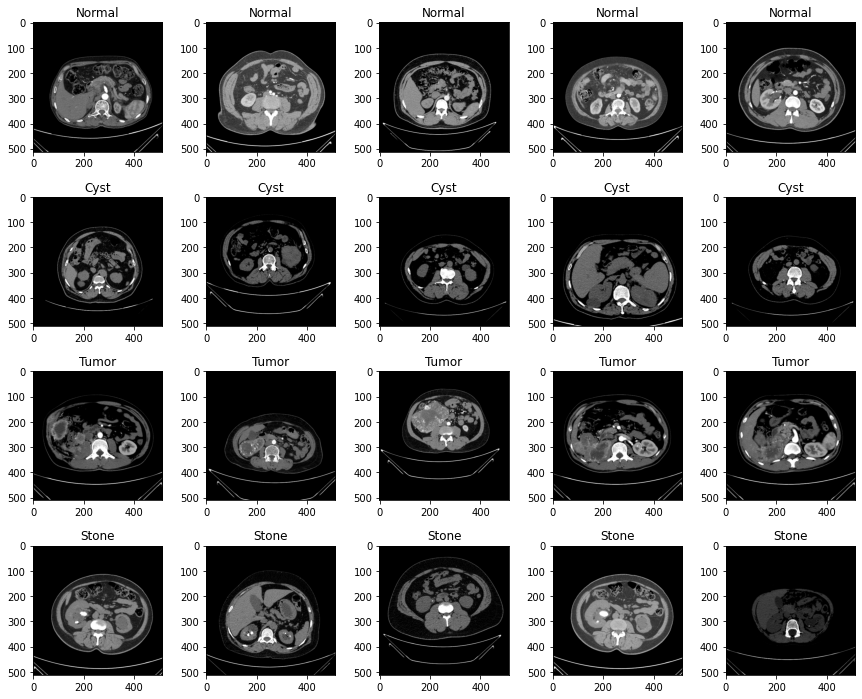

In [35]:
sample_paths = [
    sizes_df[sizes_df["category"] == c
    ]["filepath"].iloc[[6, 19, 25, 43, 47]].tolist()
    for c in categories]
sample_paths = [x for y in sample_paths for x in y]

fig, axes = plt.subplots(figsize=(15, 12), nrows=4, ncols=5)
plt.subplots_adjust(hspace=0.35)

for r in range(4):
  for c in range(5):
    img = mpimg.imread(sample_paths[r * 5 + c])
    axes[r][c].imshow(img, cmap="gray")
    axes[r][c].set_title(categories[r])
plt.show()

In [36]:
np.array(Image.open(sizes_df["filepath"].iloc[0])).max()

255

# III. Data Preprocessing & Augmentation

In [37]:
input_folder = "/content/sorted_kidney_ct_scans/"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        input_folder + "train",
        target_size=(150, 150),
        batch_size=32,
        class_mode="categorical")

validation_generator = train_datagen.flow_from_directory(
        input_folder + "val",
        target_size=(150, 150),
        batch_size=32,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        input_folder + "test",
        target_size=(150, 150),
        batch_size=32,
        class_mode="categorical")

Found 5393 images belonging to 4 classes.
Found 1540 images belonging to 4 classes.
Found 776 images belonging to 4 classes.


In [38]:
train_generator.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

In [39]:
train_generator.image_shape

(150, 150, 3)

# IV. Build Convolutional Neural Network Model

In [40]:
model = Sequential()
# add the convolutional layer
# filters, size of filters,padding,activation_function,input_shape
model.add(Conv2D(32, (5, 5), padding="SAME", activation="relu", 
                 input_shape=(150, 150, 3)))
# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# place a dropout layer
model.add(Dropout(0.5))

# add another convolutional layer
model.add(Conv2D(64, (5, 5), padding="SAME", activation="relu"))
# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# place a dropout layer
model.add(Dropout(0.5))

# Flatten layer
model.add(Flatten())
# add a dense layer : amount of nodes, activation
model.add(Dense(256, activation="relu"))
# place a dropout layer
# 0.5 drop out rate is recommended, half input nodes will be dropped at each update
model.add(Dropout(0.5))
model.add(Dense(4, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

# V. Compile & Train the Model

In [41]:
#compile the model
model.compile(
    Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [42]:
#train the model
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=validation_generator)

Epoch 1/20
169/169 [==============================] - 66s 340ms/step - loss: 1.1441 - accuracy: 0.5717 - val_loss: 1.2175 - val_accuracy: 0.4610
Epoch 2/20
169/169 [==============================] - 58s 345ms/step - loss: 0.5801 - accuracy: 0.7773 - val_loss: 0.7063 - val_accuracy: 0.6890
Epoch 3/20
169/169 [==============================] - 57s 340ms/step - loss: 0.3420 - accuracy: 0.8780 - val_loss: 0.1591 - val_accuracy: 0.9675
Epoch 4/20
169/169 [==============================] - 60s 357ms/step - loss: 0.2162 - accuracy: 0.9264 - val_loss: 0.1662 - val_accuracy: 0.9429
Epoch 5/20
169/169 [==============================] - 57s 337ms/step - loss: 0.1665 - accuracy: 0.9438 - val_loss: 0.1133 - val_accuracy: 0.9675
Epoch 6/20
169/169 [==============================] - 57s 339ms/step - loss: 0.1410 - accuracy: 0.9481 - val_loss: 0.0542 - val_accuracy: 0.9838
Epoch 7/20
169/169 [==============================] - 60s 355ms/step - loss: 0.1053 - accuracy: 0.9637 - val_loss: 0.0970 - val_ac

# VI. Performance Evaluation


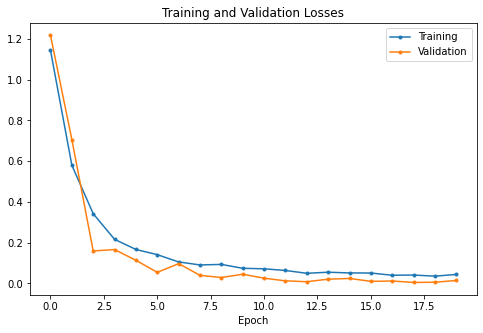

In [52]:
#plot graph between training and validation loss
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(history.history["loss"], marker=".")
ax.plot(history.history["val_loss"], marker = ".")
ax.legend(["Training", "Validation"])
ax.set_title("Training and Validation Losses")
ax.set_xlabel("Epoch")
plt.show()

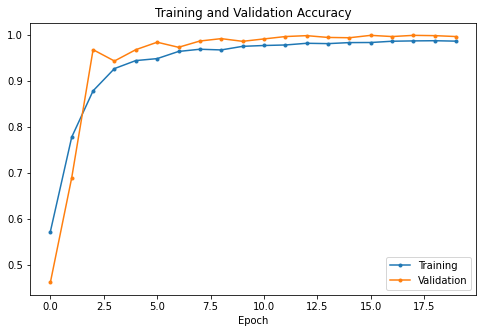

In [53]:
#plot graph between training and validation accuracy
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(history.history["accuracy"], marker=".")
ax.plot(history.history["val_accuracy"], marker = ".")
ax.legend(["Training", "Validation"])
ax.set_title("Training and Validation Accuracy")
ax.set_xlabel("Epoch")
plt.show()

In [54]:
# get the test acuarcy and loss
test_loss, test_acc = model.evaluate(test_generator)
print("test loss :{} test acc :{}".format(test_loss, test_acc))

25/25 [==============================] - 3s 138ms/step - loss: 0.0116 - accuracy: 0.9974
test loss :0.011577939614653587 test acc :0.9974226951599121


**Achieved an accuracy of over 99.7%!**